## Import Library

In [ ]:
import numpy as np
import pandas as pd
import cv2, os
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import random
import splitfolders


device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Gatehring Data

In [ ]:
data_path = '/content/drive/MyDrive/dataset fix'

In [ ]:
#Checking the number of Images each Folder

for i in os.listdir(data_path):
    new_loc = os.path.join(data_path, i)
    new_jpg = os.path.join(new_loc, '*.jpg')
    new_JPG = os.path.join(new_loc, '*.JPG')

    images_jpg = glob(new_jpg)
    images_JPG = glob(new_JPG)

    total_images = len(images_jpg) + len(images_JPG)

    print(f'{i}: {total_images} images')

potato_late_blight: 504 images
potato_healthy: 500 images
potato_early_blight: 500 images
tomato_late_blight: 500 images
tomato_early_blight: 500 images
tomato_healthy: 500 images
cucumber_healty: 500 images
cucumber_unhealthy: 500 images


In [ ]:
# Getting the classes
classes = os.listdir(data_path)
print(classes)

['potato_late_blight', 'potato_healthy', 'potato_early_blight', 'tomato_late_blight', 'tomato_early_blight', 'tomato_healthy', 'cucumber_healty', 'cucumber_unhealthy']


## Data Preparation

In [ ]:
pip install split-folders

In [ ]:

splitfolders.ratio(data_path,seed = 1337 , output = 'train-test-splitted' , ratio = (0.6,0.2,0.2))

Copying files: 4004 files [00:58, 67.92 files/s] 


In [ ]:
train_data_dir = '/content/train-test-splitted/train'
test_data_dir = '/content/train-test-splitted/test'
val_data_dir = '/content/train-test-splitted/val'

In [ ]:
# Performing the Image Transformation and Data Augmentation on the

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0, contrast=0.2, saturation=0, hue=0),
])

# Augmentation on test images not needed
transform_tests = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),

    ])


In [ ]:
# using ImageFolder function for fetching data from directory
train_data = datasets.ImageFolder(train_data_dir,transform=transform_train)
test_data = datasets.ImageFolder(test_data_dir,transform=transform_tests)

train_loader = DataLoader(train_data,batch_size=24,drop_last=True,shuffle=True,num_workers=2)
validation_loader = DataLoader(test_data, batch_size =24, drop_last=True,shuffle=True,num_workers=2)

In [ ]:
print(len(train_data))
print(len(test_data))

2402
802


In [ ]:
examples = next(iter(train_loader))
for label , img in enumerate(examples) :
  print(img.shape)

torch.Size([24, 3, 224, 224])
torch.Size([24])


Gambar acak dari data train loader:


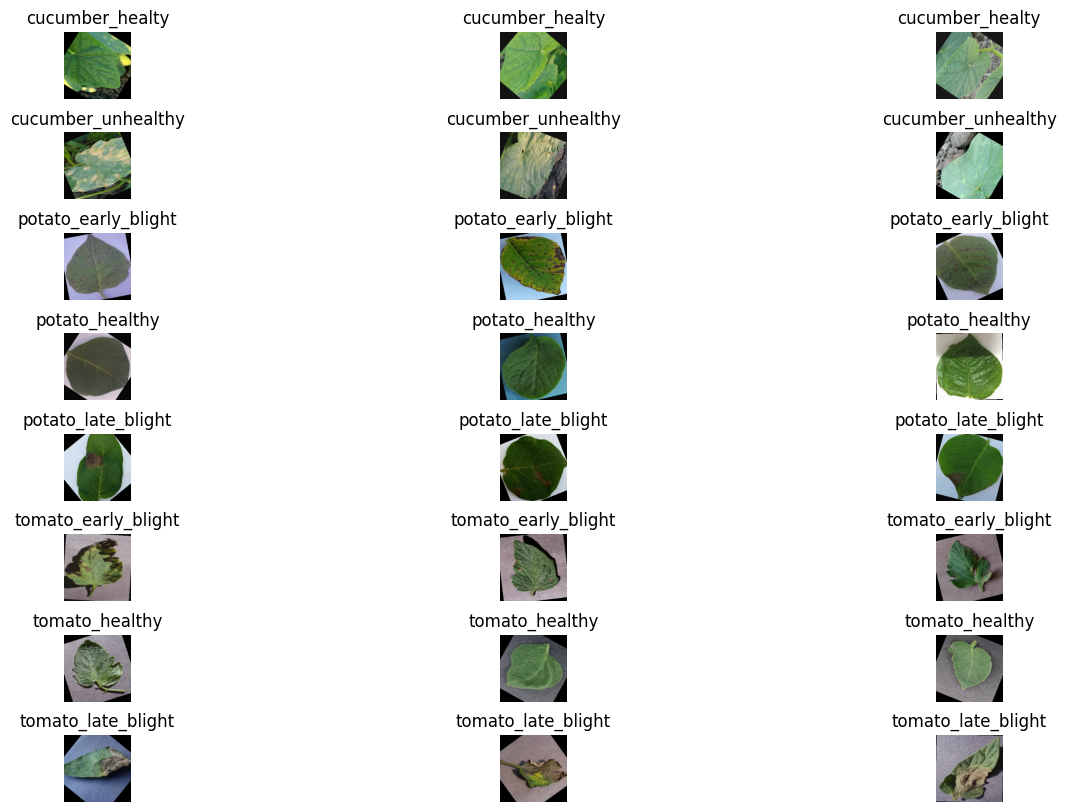

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan gambar secara acak dari loader secara horizontal
def show_random_images(loader, classes, num_images_per_class=3):
    dataiter = iter(loader)

    # Membuat subplots dengan baris sesuai dengan jumlah kelas
    num_classes = len(classes)
    fig, axes = plt.subplots(nrows=num_classes, ncols=num_images_per_class, figsize=(15, 10))

    for i, class_name in enumerate(classes):
        # Mengambil gambar secara acak dari loader untuk kelas tertentu
        class_indices = np.where(np.array(loader.dataset.targets) == i)[0]
        selected_indices = np.random.choice(class_indices, size=num_images_per_class, replace=False)

        for j, idx in enumerate(selected_indices):
            images, labels = loader.dataset[idx]
            ax = axes[i, j] if num_classes > 1 else axes[j]
            ax.imshow(np.transpose(images.numpy(), (1, 2, 0)))
            ax.set_title(class_name)
            ax.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# Classes dari dataset
classes = train_data.classes

# Menampilkan gambar acak dari data train loader
print("Gambar acak dari data train loader:")
show_random_images(train_loader, classes)

## Build EfficientNet Model

In [ ]:
pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=958265913a5bc4f79d0b5211e2331a705df5e241a176496e550cabbe9f5d4c67
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class ModifiedEfficientNet(nn.Module):
    def __init__(self, num_classes, model_name='efficientnet-b0', dropout_rate=0.2):
        super(ModifiedEfficientNet, self).__init__()

        # Load the pre-trained EfficientNet model
        self.efficientnet = EfficientNet.from_pretrained(model_name)

        # Additional convolutional layer with dropout
        self.additional_conv = nn.Sequential(
            nn.Conv2d(1280, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
        )

        # Modify the final fully connected layer
        in_features = self.efficientnet._fc.in_features
        self.additional_fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(64, num_classes)
        )

        # Modify the final fully connected layer of EfficientNet
        self.efficientnet._fc = nn.Identity()

    def forward(self, x):
        # Forward pass through the EfficientNet model
        x = self.efficientnet.extract_features(x)

        # Additional convolutional layers with dropout
        x = self.additional_conv(x)

        # Global average pooling
        x = x.mean([2, 3])

        # Additional fully connected layers with dropout
        x = self.additional_fc(x)

        return x

# Instantiate the modified EfficientNet model with 2 convolutional layers and dropout
num_classes = 8
dropout_rate = 0.2
model = ModifiedEfficientNet(num_classes, dropout_rate=dropout_rate)

# Print the model architecture
print(model)

Loaded pretrained weights for efficientnet-b0
ModifiedEfficientNet(
  (efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity(

## Training Model

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
num_epochs = 30
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    running_loss_train = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        running_loss_train += loss.item()

    train_accuracy = (correct_train / total_train) * 100
    train_loss = (running_loss_train / len(train_loader)) * 100
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Test the model
    model.eval()
    correct_test = 0
    total_test = 0
    running_loss_test = 0.0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            running_loss_test += loss.item()

    test_accuracy = (correct_test / total_test) * 100
    test_loss = (running_loss_test / len(validation_loader)) * 100
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    # Print and log metrics
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.2f}%, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

Epoch 1/30, Train Loss: 50.29%, Train Accuracy: 84.29%, Test Loss: 265.17%, Test Accuracy: 65.53%
Epoch 2/30, Train Loss: 25.51%, Train Accuracy: 92.25%, Test Loss: 127.48%, Test Accuracy: 71.59%
Epoch 3/30, Train Loss: 17.68%, Train Accuracy: 94.67%, Test Loss: 16.51%, Test Accuracy: 95.08%
Epoch 4/30, Train Loss: 14.25%, Train Accuracy: 95.83%, Test Loss: 27.85%, Test Accuracy: 92.17%
Epoch 5/30, Train Loss: 14.06%, Train Accuracy: 95.67%, Test Loss: 7.19%, Test Accuracy: 97.60%
Epoch 6/30, Train Loss: 9.15%, Train Accuracy: 97.29%, Test Loss: 24.95%, Test Accuracy: 94.19%
Epoch 7/30, Train Loss: 11.49%, Train Accuracy: 96.58%, Test Loss: 35.31%, Test Accuracy: 92.05%
Epoch 8/30, Train Loss: 11.02%, Train Accuracy: 97.12%, Test Loss: 7.39%, Test Accuracy: 97.85%
Epoch 9/30, Train Loss: 7.68%, Train Accuracy: 97.83%, Test Loss: 17.20%, Test Accuracy: 95.83%
Epoch 10/30, Train Loss: 9.72%, Train Accuracy: 96.83%, Test Loss: 6.97%, Test Accuracy: 98.23%
Epoch 11/30, Train Loss: 6.95%, T

Training 30 epochs selama +-22menit

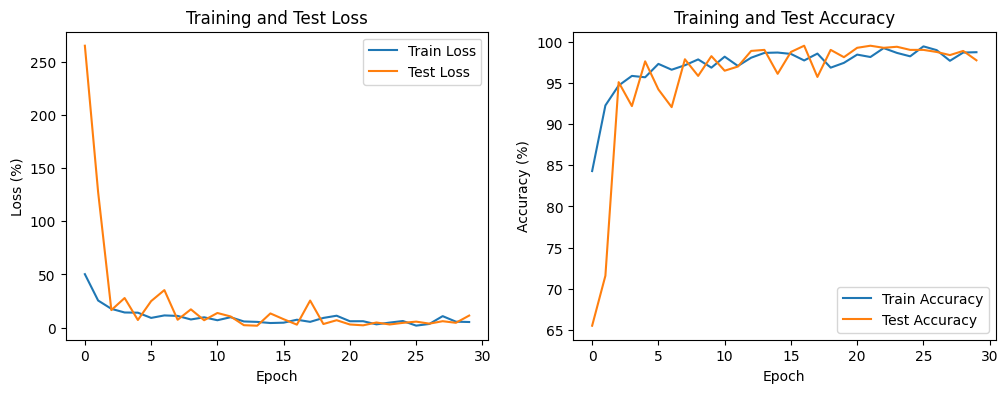

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

## Evaluate Model


Classification Report:
                     precision    recall  f1-score   support

    cucumber_healty       0.99      1.00      0.99        98
 cucumber_unhealthy       1.00      0.99      0.99        98
potato_early_blight       0.90      0.99      0.94        98
     potato_healthy       0.98      0.98      0.98        99
 potato_late_blight       0.98      0.97      0.98       101
tomato_early_blight       0.99      0.98      0.98        98
     tomato_healthy       1.00      0.94      0.97       100
 tomato_late_blight       0.99      0.97      0.98       100

           accuracy                           0.98       792
          macro avg       0.98      0.98      0.98       792
       weighted avg       0.98      0.98      0.98       792



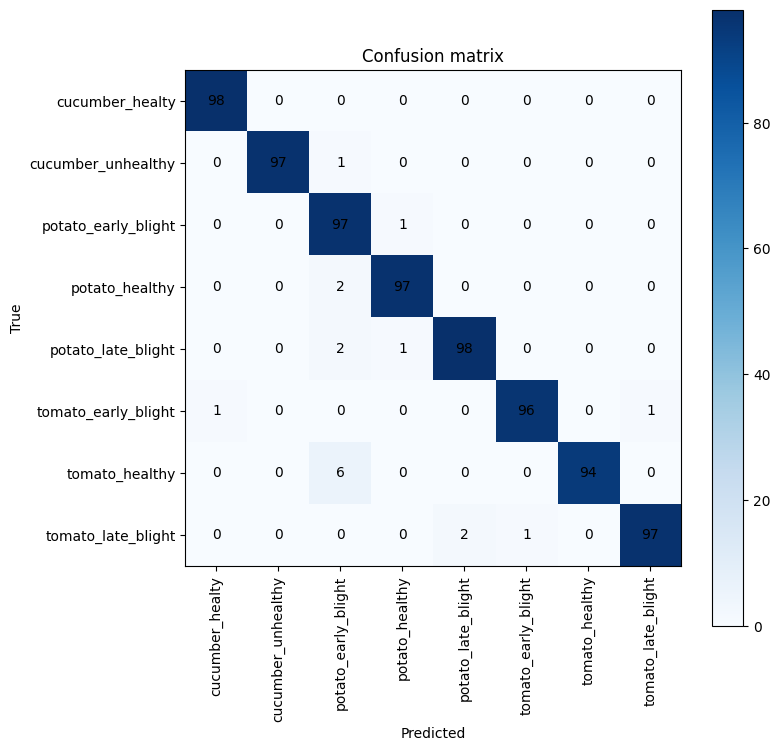

In [ ]:

# Fungsi untuk mendapatkan prediksi model
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Mendapatkan prediksi dan label sebenarnya
model.eval()
y_pred, y_true = get_predictions(model, validation_loader)

# Membuat confusion matrix dan classification report
cm = confusion_matrix(y_true, y_pred)

class_names = classes

# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Menampilkan confusion matrix dalam bentuk gambar
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

# Menampilkan nama kelas di sumbu x dan y
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

# Menambahkan nilai di setiap kotak confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Predict

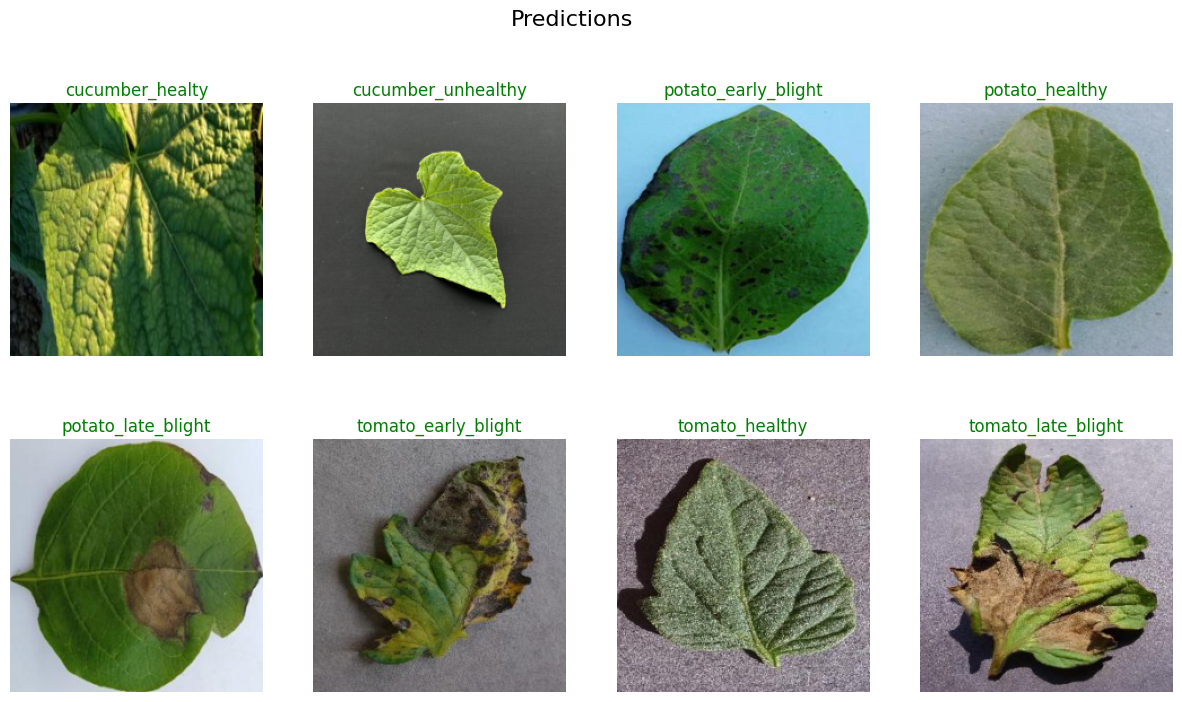

In [ ]:



class_names = classes

# Load trained model here
model = model
model.eval()

# Transform for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Path to the test images folder
test_folder = "/content/train-test-splitted/test"

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up a subplot for the predictions
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Predictions', fontsize=16)

# Iterate through all subplots
for i in range(2):
    for j in range(4):
        # Calculate the index in the flat iteration
        index = i * 4 + j

        # Skip if all images have been processed
        if index >= len(class_names):
            break

        # Get the class name for the current subplot
        class_name = class_names[index]

        # Get the list of image files for the class
        class_folder = os.path.join(test_folder, class_name)
        image_files = os.listdir(class_folder)

        # Determine the number of images to predict
        num_images_to_predict = 2 if i == 0 and j < 2 else 1

        # Skip if there are not enough images
        if len(image_files) < num_images_to_predict:
            continue

        # Randomly select different images for each prediction
        image_indices = random.sample(range(len(image_files)), num_images_to_predict)

        # Iterate over selected image indices
        for k in range(num_images_to_predict):
            image_index = image_indices[k]
            image_path = os.path.join(class_folder, image_files[image_index])
            img = Image.open(image_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)

            # Make prediction
            with torch.no_grad():
                output = model(img)
                _, predicted = torch.max(output, 1)
                predicted_class = class_names[predicted.item()]

            # Display the image with title
            axs[i, j].imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())  # Move to CPU before converting to numpy
            title_color = 'green' if predicted_class == class_name else 'red'
            axs[i, j].set_title(predicted_class, color=title_color)
            axs[i, j].axis('off')

            if title_color == 'red':
                axs[i, j].text(0.5, -0.1, 'Incorrect Prediction', color='red', transform=axs[i, j].transAxes)

plt.show()


## Save Model

In [ ]:
torch.save(model.state_dict(),'/content/save_model/model.pt')

## Load Model

In [ ]:
# load model with pickle
model.load_state_dict(torch.load('/content/save_model/model.pt'))
model.eval()

ModifiedEfficientNet(
  (efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dSta